In [0]:
from skimage import io, color
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure
import pylab

import numpy as np
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot as PLT

import pickle
import time

In [0]:
class classification_data():
    
    def __init__(self, data, coef = 4):
        """Data - pandas DataFrame with n**2 columns, which includes matrixes"""
        self.data_old = data[0]
        self.coef = coef
        self.old_dim = int(np.sqrt(self.data_old.shape[1]))
        self.new_dim = int(self.old_dim / self.coef)
        self.data_new = self.raw2raw(self.data_old)
        self.label = data[1]
        
    def convolve2d(self, image):
        output = np.zeros([int(image.shape[0]/self.coef), int(image.shape[1]/self.coef)]) 
        for x in range(output.shape[1]):    
            for y in range(output.shape[0]):
                output[y,x]=np.max(image[(self.coef*y):(self.coef*y+self.coef),(self.coef*x):(self.coef*x+self.coef)])
        return output

    def raw2raw(self, data):
        '''data - field with data, where n**2 columns. Label - is y for all objects from data'''
        n_objects = data.shape[0]
        data_new = pd.DataFrame(np.zeros((n_objects,self.new_dim**2)))
        for i in range(n_objects):
            data_new.iloc[i,:] = self.convolve2d(np.array(data.iloc[i,:]).reshape(self.old_dim,self.old_dim)).reshape(1,self.new_dim**2)
        return data_new

    def draw_mnist_convolve(self, img):
        img2 = convolve_mnist(img)
        fig = PLT.figure()

        ax1 = fig.add_subplot(121)
        ax1.imshow(img, cmap=plt.cm.gray)

        ax2 = fig.add_subplot(122)
        ax2.imshow(img2, cmap=plt.cm.gray)

        PLT.show()

    def draw_data(self, n_objects=1):
        if n_objects != 1:
            #list(np.random.randint(self.data_old.shape[0],size=(1,n_objects))[0,:]):
            print('TBD')
        else:
            for i in range(self.data_old.shape[0]):
                fig = plt.figure(figsize=(3,3))
                ax1 = fig.add_subplot(121)
                ax1.imshow(np.array(self.data_old.iloc[i,:]).reshape(self.old_dim,self.old_dim), cmap=plt.cm.gray)

                ax2 = fig.add_subplot(122)
                ax2.imshow(np.array(self.data_new.iloc[i,:]).reshape(self.new_dim,self.new_dim), cmap=plt.cm.gray)

                plt.show()

In [0]:
def generator(collection = 'mnist', n_objects = 50, class_number = 3):
    '''It is a data generation function, it's argument is "mnist" or "random". It generates this data.
    Their number is about 50 examples for 2 classes
    Returns X data and y column'''
    
    if collection == 'mnist':
        try:
            data = pd.read_csv('sample_data/mnist_test.csv',header = None)            
            X = data[(data.iloc[:,0] == 1) + (data.iloc[:,0] == 0) + (data.iloc[:,0] == 5)].sample(n_objects*class_number)
            return (X.iloc[:,1:], pd.Series(X.iloc[:,0]))
        except:
            print('No mnist data in the folder or sampling error')
            
    if collection == 'random':
        dim = 7
        data = np.zeros((n_objects*class_number,dim**2))
        labels = []
        for k in range(dim**2):
            labels.append('pixel'+str(k))
            
        for i in range(class_number):
            for j in range(n_objects):
                
                if i == 0:
                    row_index = np.random.randint(1,dim-1)
                    object_x = data[(i*n_objects + j),:].reshape(dim,dim)
                    object_x[row_index,:] += 1
                    if (np.random.randint(2)==1) and (row_index < (dim-2)):
                        object_x[(row_index + 1),:] += 1
                    data[(i*n_objects + j),:] = object_x.reshape(1,dim**2)
                
                if i == 1:
                    col_index = np.random.randint(1,dim-1)
                    object_x = data[(i*n_objects + j),:].reshape(dim,dim)
                    object_x[:,col_index] += 1
                    if (np.random.randint(2)==1) and (col_index < (dim-2)):
                        object_x[:,(col_index + 1)] += 1
                    data[(i*n_objects + j),:] = object_x.reshape(1,dim**2)
                    
        #data += np.random.random((n_objects*class_number,dim**2))/3
        data = pd.DataFrame(data,columns=labels)
        return (255*data, pd.Series([0]*n_objects + [1]*n_objects))

In [0]:
def local_cost(A,B,pi_local):
    cost = 0
    for pair in pi_local:
        cost += (A[(pair[0][0]),(pair[0][1])] - B[(pair[1][0]),(pair[1][1])])**2
    return cost

def min_index(i,j,k,l,cost_matrix):
    idx = np.argmin([cost_matrix[i,j,k,l],
                      cost_matrix[i+1,j,k+1,l],
                      cost_matrix[i,j+1,k,l+1],
                      cost_matrix[i,j+1,k+1,l+1],
                      cost_matrix[i+1,j,k+1,l+1],
                      cost_matrix[i+1,j+1,k,l+1],
                      cost_matrix[i+1,j+1,k+1,l]])
    return idx, [[i-1,j-1,k-1,l-1],
                      [i,j-1,k,l-1],
                      [i-1,j,k-1,l],
                      [i-1,j,k,l],
                      [i,j-1,k,l],
                      [i,j,k-1,l],
                      [i,j,k,l-1]][idx]

def DTW_matrix(A,B, print_results = False):
    '''A,B - N $\times$ N matrixes'''
    length = A.shape[0]

    pi_path = [[[[[] for k in range(length)]for z in range(length)]for x in range(length)] for y in range(length)]
    pi_path[0][0][0][0] = [[[0,0],[0,0]]]
    
    cost_matrix = np.zeros((length + 1, length + 1, length + 1, length + 1)) + np.inf
    cost_matrix[0,0,0,0] = 0
    cost_matrix[1,1,1,1] = cost_matrix[0,0,0,0] + (A[1,1] - B[1,1])**2

    previous_index_type = np.zeros((length , length , length , length ))
    previous_index = [[[[[] for k in range(length)]for z in range(length)]for x in range(length)] for y in range(length)]
    
    for i in range(0,length):
        for j in range(0,length):
            for k in range(max((i-5),0),min((i+5),length)):
                for l in range(max((j-5),0),min((j+5),length)):
                    
                    idx, [i_,j_,k_,l_] = min_index(i,j,k,l,cost_matrix)                      
                    
                    previous_index_type[i,j,k,l] = idx
                    previous_index[i][j][k][l] = [i_,j_,k_,l_]
                    
                    if (i,j,k,l) != (0,0,0,0): 
                        
                        if idx == 0:
                            
                            pi_path[i][j][k][l] = pi_path[i-1][j-1][k-1][l-1].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][0]==(i-1))and(x[1][0]==(k-1)))].copy()
                            pi_2 = [x for x in pi_path[i][j][k][l] if ((x[0][1]==(j-1))and(x[1][1]==(l-1)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[0][0] = i
                                pair[1][0] = k
                                
                            pi_2_ = []
                            for pair in pi_2:
                                pi_2_.append([list(x.copy()) for x in pair])
                            for pair in pi_2_:
                                pair[0][1] = j
                                pair[1][1] = l
                            
                            pi_path[i][j][k][l].extend(pi_1_)
                            pi_path[i][j][k][l].extend(pi_2_)
                            pi_path[i][j][k][l].append([[i,j],[k,l]])
                                                    
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i,j,k,l] + local_cost(A,B,pi_1_) + local_cost(A,B,pi_2_) + (A[i,j] - B[k,l])**2

                        if idx == 1:

                            pi_path[i][j][k][l] = pi_path[i][j-1][k][l-1].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][1]==(j-1))and(x[1][1]==(l-1)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[0][1] = j
                                pair[1][1] = l
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i+1,j,k+1,l] + local_cost(A,B,pi_1_)

                        if idx == 2:

                            pi_path[i][j][k][l] = pi_path[i-1][j][k-1][l].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][0]==(i-1))and(x[1][0]==(k-1)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[0][0] = i
                                pair[1][0] = k
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i,j+1,k,l+1] + local_cost(A,B,pi_1_) 

                        if idx == 3:
                            
                            pi_path[i][j][k][l] = pi_path[i-1][j][k][l].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][0]==(i-1))and(x[1][0]==(k)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[0][0] = i
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i,j+1,k+1,l+1] + local_cost(A,B,pi_1_) 

                        if idx == 4:
                            
                            pi_path[i][j][k][l] = pi_path[i][j-1][k][l].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][1]==(j-1))and(x[1][1]==(l)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[0][1] = j
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i+1,j,k+1,l+1] + local_cost(A,B,pi_1_) 

                        if idx == 5:
                            
                            pi_path[i][j][k][l] = pi_path[i][j][k-1][l].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][0]==(i))and(x[1][0]==(k-1)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[1][0] = k
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i+1,j+1,k,l+1] + local_cost(A,B,pi_1_) 
                            
                        if idx == 6:
                            
                            pi_path[i][j][k][l] = pi_path[i][j][k][l-1].copy()
                            pi_1 = [x for x in pi_path[i][j][k][l] if ((x[0][1]==j)and(x[1][1]==(l-1)))].copy()
                            
                            pi_1_ = []
                            for pair in pi_1:
                                pi_1_.append([list(x.copy()) for x in pair])
                            for pair in pi_1_:
                                pair[1][1] = l
                                                        
                            pi_path[i][j][k][l].extend(pi_1_)
                            #pi_path[i][j][k][l].append([[i,j],[k,l]])
                            
                            cost_matrix[i+1,j+1,k+1,l+1] = cost_matrix[i+1,j+1,k+1,l] + local_cost(A,B,pi_1_)
                        
                        if print_results == True:
                            print(i,j,k,l)
                            print(idx)
                            print(pi_path[i][j][k][l])
                            print(cost_matrix[i+1,j+1,k+1,l+1])
                            print(local_cost(A,B,pi_1_))
                
    return np.sqrt(cost_matrix[length,length,length,length]), cost_matrix, pi_path, previous_index
                    
                    

In [0]:
def calculate_distance(x_1, x_2, draw = False):
    len_1 = int(np.sqrt(len(x_1)))
    len_2 = int(np.sqrt(len(x_2)))
    x_1 = np.array(x_1).reshape(len_1,len_1)
    x_2 = np.array(x_2).reshape(len_2,len_2)
    Cost, cost_matrix, path, previous_index = DTW_matrix(x_1,x_2)
    if draw == True:
        fig = plt.figure(figsize=(30,10))
        ax1 = fig.add_subplot(121)

        for el in path[len_1-1][len_1-1][len_2-1][len_2-1]:
            if x_1[el[0][0],el[0][1]] >= 111:
                ax1.plot([el[0][0],el[1][0]+len_1+1],[el[0][1],el[1][1]+1])
        ax1.imshow(
                np.concatenate((
                    np.concatenate((np.array(x_1).reshape(len_1,len_1).T,np.matrix([255]*len_1))), 
                    np.matrix([255]*(len_1+1)).T,
                    np.concatenate((np.matrix([255]*len_1),np.array(x_2).reshape(len_2,len_2).T))
                ),axis = 1), cmap=plt.cm.gray)
        plt.title(Cost)
        plt.ylim(len_1+1)
        plt.show()
        
    return Cost, cost_matrix, path, previous_index

In [57]:
X = classification_data(generator(collection = 'mnist', n_objects = 20), coef=4)

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


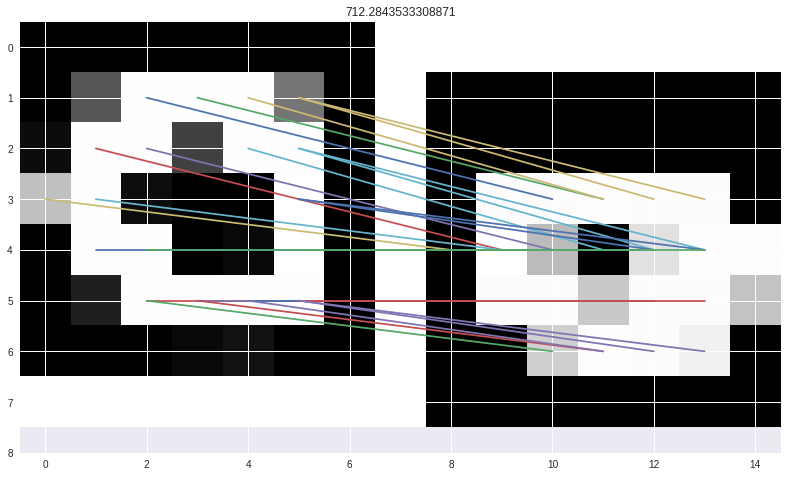

In [58]:
Cost, cost_matrix, path, previous_index = calculate_distance(X.data_new.iloc[2,:],X.data_new.iloc[3,:],draw=True)

In [59]:
N_objects = 60

print('Prepairing Data ...')
#X = classification_data(generator(collection = 'mnist', n_objects = 100), coef=2)
print('Data are ready!')
print('Processing start...')
print(' ')

processed_data = {}

for i in range(N_objects):
    print('Comparing ' + str(i)+"'s object.")
    for j in range(i):
        t = time.process_time()
        x_1 = X.data_new.iloc[i,:]
        x_2 = X.data_new.iloc[j,:]
        label_1 = X.label.iloc[i]
        label_2 = X.label.iloc[j]
        Cost, cost_matrix, path, previous_index = calculate_distance(x_1,x_2)
        object_dict = {'object_1': x_1, 
                       'object_2': x_2,
                       'label_1': label_1, 
                       'label_2': label_2,
                       'cost': Cost, 
                       'euclidean_dist': np.sum((x_1-x_2)**2),
                       'path': path[6][6][6][6], 
                       'cost_matrix': cost_matrix, 
                       'previous_index': previous_index,
                       'processed_time':time.process_time() - t}
        processed_data.update({str(i)+'.'+str(j):object_dict})

print('Processing finished.')

with open('processed_mnist_[0,1]x60.pickle', 'wb') as handle:
    pickle.dump(processed_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print('File saved.')

Prepairing Data ...
Data are ready!
Processing start...
 
Comparing 0's object.
Comparing 1's object.
Comparing 2's object.
Comparing 3's object.
Comparing 4's object.
Comparing 5's object.
Comparing 6's object.
Comparing 7's object.
Comparing 8's object.
Comparing 9's object.
Comparing 10's object.
Comparing 11's object.
Comparing 12's object.
Comparing 13's object.
Comparing 14's object.
Comparing 15's object.
Comparing 16's object.
Comparing 17's object.
Comparing 18's object.
Comparing 19's object.
Comparing 20's object.
Comparing 21's object.
Comparing 22's object.
Comparing 23's object.
Comparing 24's object.
Comparing 25's object.
Comparing 26's object.
Comparing 27's object.
Comparing 28's object.
Comparing 29's object.
Comparing 30's object.
Comparing 31's object.
Comparing 32's object.
Comparing 33's object.
Comparing 34's object.
Comparing 35's object.
Comparing 36's object.
Comparing 37's object.
Comparing 38's object.
Comparing 39's object.
Comparing 40's object.
Comparing

In [12]:
N_objects = 100

print('Prepairing Data ...')
#X = classification_data(generator(collection = 'mnist', n_objects = 100), coef=2)
print('Data are ready!')
print('Processing start...')
print(' ')

processed_data = {}

for i in range(50,75):
    print('Comparing ' + str(i)+"'s object.")
    for j in range(i):
        t = time.process_time()
        x_1 = X.data_new.iloc[i,:]
        x_2 = X.data_new.iloc[j,:]
        label_1 = X.label.iloc[i]
        label_2 = X.label.iloc[j]
        Cost, cost_matrix, path, previous_index = calculate_distance(x_1,x_2)
        object_dict = {'object_1': x_1, 
                       'object_2': x_2,
                       'label_1': label_1, 
                       'label_2': label_2,
                       'cost': Cost, 
                       'euclidean_dist': np.sum((x_1-x_2)**2),
                       'path': path[13][13][13][13], 
                       'cost_matrix': cost_matrix, 
                       'previous_index': previous_index,
                       'processed_time':time.process_time() - t}
        processed_data.update({str(i)+'.'+str(j):object_dict})

print('Processing finished.')

with open('processed_mnist_[0,1]x50-75.pickle', 'wb') as handle:
    pickle.dump(processed_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print('File saved.')

Prepairing Data ...
Data are ready!
Processing start...
 
Comparing 50's object.
Comparing 51's object.
Comparing 52's object.
Comparing 53's object.
Comparing 54's object.
Comparing 55's object.
Comparing 56's object.
Comparing 57's object.
Comparing 58's object.
Comparing 59's object.
Comparing 60's object.
Comparing 61's object.
Comparing 62's object.
Comparing 63's object.
Comparing 64's object.
Comparing 65's object.
Comparing 66's object.
Comparing 67's object.
Comparing 68's object.
Comparing 69's object.
Comparing 70's object.
Comparing 71's object.
Comparing 72's object.
Comparing 73's object.
Comparing 74's object.
Processing finished.
File saved.


In [13]:
N_objects = 100

print('Prepairing Data ...')
#X = classification_data(generator(collection = 'mnist', n_objects = 100), coef=2)
print('Data are ready!')
print('Processing start...')
print(' ')

processed_data = {}

for i in range(75,90):
    print('Comparing ' + str(i)+"'s object.")
    for j in range(i):
        t = time.process_time()
        x_1 = X.data_new.iloc[i,:]
        x_2 = X.data_new.iloc[j,:]
        label_1 = X.label.iloc[i]
        label_2 = X.label.iloc[j]
        Cost, cost_matrix, path, previous_index = calculate_distance(x_1,x_2)
        object_dict = {'object_1': x_1, 
                       'object_2': x_2,
                       'label_1': label_1, 
                       'label_2': label_2,
                       'cost': Cost, 
                       'euclidean_dist': np.sum((x_1-x_2)**2),
                       'path': path[13][13][13][13], 
                       'cost_matrix': cost_matrix, 
                       'previous_index': previous_index,
                       'processed_time':time.process_time() - t}
        processed_data.update({str(i)+'.'+str(j):object_dict})

print('Processing finished.')

with open('processed_mnist_[0,1]x75-90.pickle', 'wb') as handle:
    pickle.dump(processed_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print('File saved.')

Prepairing Data ...
Data are ready!
Processing start...
 


KeyboardInterrupt: ignored

In [14]:
N_objects = 100

print('Prepairing Data ...')
#X = classification_data(generator(collection = 'mnist', n_objects = 100), coef=2)
print('Data are ready!')
print('Processing start...')
print(' ')

processed_data = {}

for i in range(90,100):
    print('Comparing ' + str(i)+"'s object.")
    for j in range(i):
        t = time.process_time()
        x_1 = X.data_new.iloc[i,:]
        x_2 = X.data_new.iloc[j,:]
        label_1 = X.label.iloc[i]
        label_2 = X.label.iloc[j]
        Cost, cost_matrix, path, previous_index = calculate_distance(x_1,x_2)
        object_dict = {'object_1': x_1, 
                       'object_2': x_2,
                       'label_1': label_1, 
                       'label_2': label_2,
                       'cost': Cost, 
                       'euclidean_dist': np.sum((x_1-x_2)**2),
                       'path': path[13][13][13][13], 
                       'cost_matrix': cost_matrix, 
                       'previous_index': previous_index,
                       'processed_time':time.process_time() - t}
        processed_data.update({str(i)+'.'+str(j):object_dict})

print('Processing finished.')

with open('processed_mnist_[0,1]x90-100.pickle', 'wb') as handle:
    pickle.dump(processed_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print('File saved.')

Prepairing Data ...
Data are ready!
Processing start...
 
Comparing 90's object.
Comparing 91's object.
Comparing 92's object.
Comparing 93's object.
Comparing 94's object.
Comparing 95's object.
Comparing 96's object.
Comparing 97's object.
Comparing 98's object.
Comparing 99's object.
Processing finished.
File saved.


In [6]:
print('Prepairing Data ...')
#X = classification_data(generator(collection = 'mnist', n_objects = 100), coef=2)
print('Data are ready!')
print('Processing start...')
print(' ')

Distances_dtw = np.zeros((100,100))
Distances_euc = np.zeros((100,100))

with open('processed_mnist_[0,1]x0-50.pickle', 'rb') as handle:
    processed_data_ = pickle.load(handle)
    handle.close()

for i in range(0,50):
    for j in range(i):
        Distances_dtw[i,j] = processed_data_[str(i)+'.'+str(j)]['cost']
        Distances_euc[i,j] = processed_data_[str(i)+'.'+str(j)]['euclidean_dist']
        


Prepairing Data ...
Data are ready!
Processing start...
 


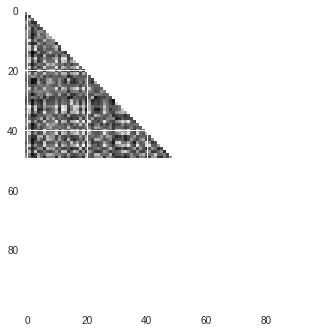

In [7]:
plt.imshow(Distances_dtw)

In [0]:
Distances_dtw = Distances_dtw + Distances_dtw.T
for i in range(100):
    Distances_dtw[i,i] = np.inf
id_closest = [np.argmin(x) for x in Distances_dtw[:50,:50]]
labels = np.zeros(50)
for i in range(0,49):
    labels[i] = processed_data_[str(49)+'.'+str(i)]['label_2']
for i in range(50):
  if labels[id_closest[i]] == labels[i]:
    print(True)
  else:
    print(False)


In [0]:
Distances_dtw = np.matrix(Distances_dtw)

In [0]:
Distances_dtw.

In [34]:
Distances_euc = Distances_euc + Distances_euc.T
for i in range(100):
    Distances_euc[i,i] = np.inf
id_closest = [np.argmin(x) for x in Distances_euc[:50,:50]]
labels = np.zeros(50)
for i in range(0,49):
    labels[i] = processed_data_[str(49)+'.'+str(i)]['label_2']
for i in range(50):
  if labels[id_closest[i]] == labels[i]:
    print(True)
  else:
    print(False)



True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
